In [178]:
from ema_workbench import load_results
import pandas as pd
import statsmodels.api as sm
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
import numpy as np
desired_width = 320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',50)
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from dike_model_simulation import problem_formulation
from SALib.analyze import sobol
import seaborn as sns
import matplotlib.pyplot as plt
import os
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

Sobol_outcome_file = './results/run_sobol.tar.gz'
results_file = './results/run_1.tar.gz'
run_name = policy_sensitvity
run_sensitivity_analysis('./results/run_sobol.tar.gz', './results/run_1.tar.gz', run_name)

In [114]:
def run_sensitivity_analysis(Sobol, regular, name):
    if not os.path.exists(f'./results/{name}'):
        os.mkdir(f'./results/{name}')
    else:
        shutil.rmtree('dir_path')
        os.mkdir(f'./results/{name}')
    experiments, outcomes = load_results(regular)
    experiments_sobol, outcomes_sobol = load_results(Sobol_outcome_file)
    df_outcomes = setup_dataframe_outcomes(outcomes)
    df_outcomes_sobol = setup_dataframe_outcomes(outcomes_sobol)

    df_experiments = experiments.drop(['policy', 'model', 'scenario'], axis = 1)
    df_experiments_sobol = experiments_sobol.drop(['policy', 'model', 'scenario'], axis = 1)
    run_regression ('Total_Expected_Number_of_Deaths', df_outcomes, df_experiments, name)
    run_regression ('Total_Dike_Investment_Costs', df_outcomes, df_experiments, name)
    run_regression ('Total_Expected_Anual_Dagame', df_outcomes, df_experiments, name)
    run_regression ('Expected_evacuation_costs', df_outcomes, df_experiments, name)
    run_regression ('RfR_Total_Costs', df_outcomes, df_experiments, name)

    problem = get_SALib_problem(dike_model.uncertainties)

    run_sobol (df_outcomes_sobol, 'Total_Expected_Number_of_Deaths', problem)
    run_sobol (df_outcomes_sobol, 'Total_Dike_Investment_Costs', problem)
    run_sobol (df_outcomes_sobol, 'Total_Expected_Anual_Dagame)', problem)
    run_sobol (df_outcomes_sobol, 'Expected_evacuation_costs', problem)
    run_sobol (df_outcomes_sobol, 'RfR_Total_Costs', problem)

    check_num_scenario (df_outcomes_sobol, 'Total_Expected_Number_of_Deaths', problem)
    check_num_scenario (df_outcomes_sobol, 'Total_Dike_Investment_Costs', problem)
    check_num_scenario (df_outcomes_sobol, 'Total_Expected_Anual_Dagame)', problem)
    check_num_scenario (df_outcomes_sobol, 'Expected_evacuation_costs', problem)
    check_num_scenario (df_outcomes_sobol, 'RfR_Total_Costs', problem)



In [115]:
def setup_dataframe_outcomes (outcomes):
    outcome = {f'{key} {i + 1}': value[:, i] for key, value in outcomes.items() for i in range(value.shape[1])}
    df_outcomes = pd.DataFrame(outcome)
    for i in range(1,6):
        df_outcomes[f'A.{i}_Expected_Anual_Dagame'] = (df_outcomes[[col for col in df_outcomes.columns if col.startswith(f'A.{i}_Expected Annual Damage')]].sum(axis=1))*(200/len(planning_steps))
        df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith(f'A.{i}_Expected Annual Damage')], axis=1)

        df_outcomes[f'A.{i}_Dike_Investment_Costs'] = df_outcomes[[col for col in df_outcomes.columns if col.startswith(f'A.{i}_Dike Investment Costs')]].sum(axis=1)
        df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith(f'A.{i}_Dike Investment Costs')], axis=1)

        df_outcomes[f'A.{i}_Expected_Number_of_Deaths'] = df_outcomes[[col for col in df_outcomes.columns if col.startswith(f'A.{i}_Expected Number of Deaths')]].sum(axis=1)*(200/len(planning_steps))
        df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith(f'A.{i}_Expected Number of Deaths')], axis=1)

    df_outcomes['RfR_Total_Costs'] = df_outcomes[[col for col in df_outcomes.columns if col.startswith('RfR Total Costs')]].sum(axis=1)
    df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith('RfR Total Costs')], axis=1)

    df_outcomes['Expected_evacuation_costs'] = df_outcomes[[col for col in df_outcomes.columns if col.startswith('Expected Evacuation Costs')]].sum(axis=1)
    df_outcomes = df_outcomes.drop(df_outcomes.columns[df_outcomes.columns.str.startswith('Expected Evacuation Costs')], axis=1)

    df_outcomes['Total_Expected_Number_of_Deaths'] = df_outcomes[[col for col in df_outcomes.columns if col.endswith('Expected_Number_of_Deaths')]].sum(axis=1)
    df_outcomes['Total_Dike_Investment_Costs'] = df_outcomes[[col for col in df_outcomes.columns if col.endswith('Dike_Investment_Costs')]].sum(axis=1)
    df_outcomes['Total_Expected_Anual_Dagame'] = df_outcomes[[col for col in df_outcomes.columns if col.endswith('Expected_Anual_Dagame')]].sum(axis=1)
    return df_outcomes

In [128]:
def run_regression (kpi, df_outcomes, df_experiments, name):
    final_lhs = df_outcomes[kpi]
    X_0 = sm.add_constant(df_experiments)
    est = sm.OLS(final_lhs, X_0.astype(float)).fit()
    parameters_df = pd.DataFrame(est.params, columns=['Parameter'])
    parameters_df.index.name = 'Variable'
    # Save parameters to CSV
    parameters_df.to_csv(f'./results/{name}/parameters_{kpi}.csv')
    # Save summary to CSV
    with open(f'./results/{name}/summary_{kpi}.txt', 'w') as f:
        f.write(est.summary().as_text())

                                   OLS Regression Results                                  
Dep. Variable:     Total_Expected_Number_of_Deaths   R-squared:                       1.000
Model:                                         OLS   Adj. R-squared:                    nan
Method:                              Least Squares   F-statistic:                       nan
Date:                             Wed, 07 Jun 2023   Prob (F-statistic):                nan
Time:                                     09:15:08   Log-Likelihood:                 278.52
No. Observations:                               10   AIC:                            -537.0
Df Residuals:                                    0   BIC:                            -534.0
Df Model:                                        9                                         
Covariance Type:                         nonrobust                                         
                              coef    std err          t      P>|t|      [0.025 

C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\lvanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
C:\Users\lvanv\AppData\Local\Programs\Pyt

#### 2. Sobol

                                   ST       ST_conf
A.0_ID flood wave shape  5.978090e-03  2.864948e-03
A.1_Bmax                 1.008506e-02  9.014100e-03
A.1_Brate                1.813292e-04  2.703547e-04
A.1_pfail                6.879717e-01  1.974969e-01
A.2_Bmax                 3.082026e-04  3.938530e-04
A.2_Brate                1.857818e-06  3.113023e-06
A.2_pfail                2.322835e-02  1.282465e-02
A.3_Bmax                 1.041905e-05  9.105649e-06
A.3_Brate                4.937273e-06  8.409219e-06
A.3_pfail                2.161811e-01  8.526887e-02
A.4_Bmax                 8.798210e-09  1.417266e-08
A.4_Brate                1.090517e-08  1.756668e-08
A.4_pfail                1.232326e-03  1.125807e-03
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                2.202039e-02  1.416384e-02
discount rate 0          1.062307e-02  4.560507e-03
discount rate 1          1.010681e-02  3.306700e-03
discount rat

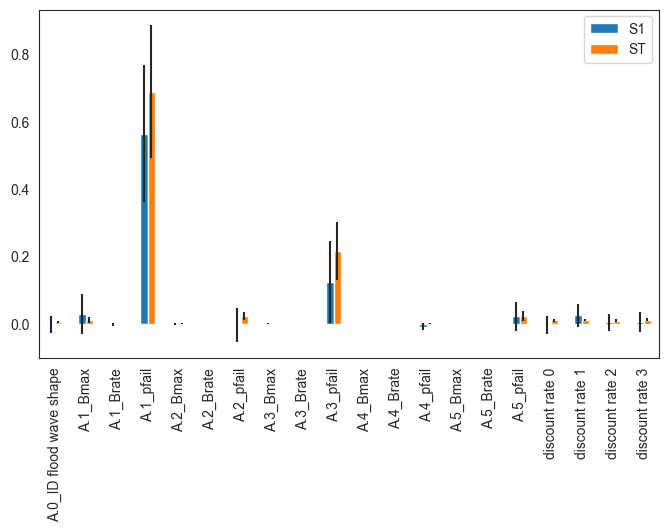

In [181]:
def run_sobol (df_outcomes_sobol, kpi, problem):
    final_sobol = df_outcomes_sobol[kpi].to_numpy()
    Si = sobol.analyze(problem, final_sobol, calc_second_order=True, print_to_console=True)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.savefig(f'./results/{name}/sobol_plot_{kpi}.png')


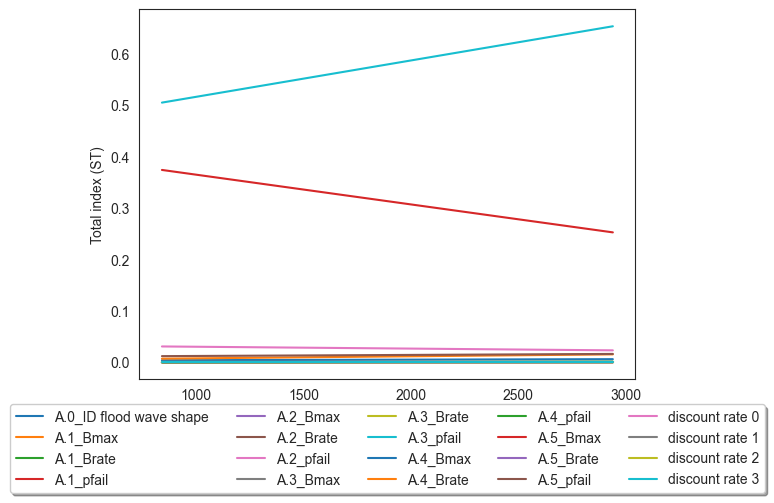

In [188]:
def check_num_scenario (df_outcomes_sobol, kpi, problem):
    Y = df_outcomes_sobol[kpi].to_numpy()
    s_data = pd.DataFrame(index=problem['names'],
                          columns=np.arange(20,100,50)*(2*problem['num_vars']+2))
    for j in s_data.columns:
        scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
        s_data.loc[:,j] = scores['ST']
    fig, ax = plt.subplots(1)

    s_data.T.plot(ax=ax)
    ax.set_xlabel('Samples')
    ax.set_ylabel('Total index (ST)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    plt.savefig(f'./results/{name}/scenario_check_plot_{kpi}.png')